### Examine the Data

In [43]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import pickle
import statsmodels.api as sm

In [44]:

# Read the dataset
df_raw = pd.read_csv('waterTank_Golden_reduced.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


### Plot the source data

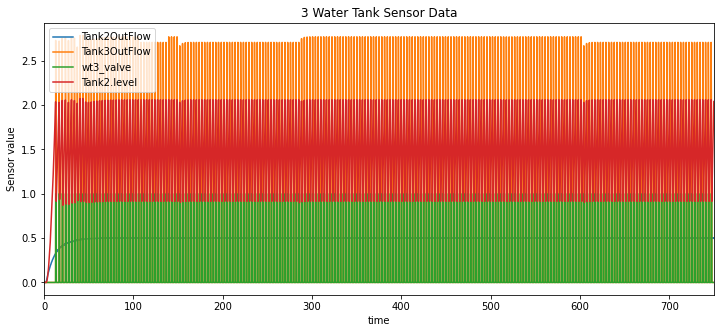

In [45]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank2OutFlow'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank2.puddle'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [46]:
len(df_raw)

15001

In [47]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [48]:
adf_test(df_raw['Tank2.puddle'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.158867e+01
p-value                 2.826590e-21
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [49]:
# All the correlated features are stationary.
df_raw.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,0.0,0.022568,0.0,0.0,0
0.05,0.0,0.022568,0.0,0.0,0
0.10,0.0,0.022568,0.0,0.0,0
0.15,0.0,0.022568,0.0,0.0,0
0.20,0.0,0.022568,0.0,0.0,0


### Normalisation of the dataset

In [50]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
#     return pd.DataFrame(normalised_data), means, stds
    return pd.DataFrame(normalised_data), means, stds


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data, means, stds = normalise_timeseries(df_raw)



In [51]:
# norm_vars = pd.concat([means, stds], axis=1)
# norm_vars

In [52]:
# norm_vars.to_csv(file_path)

### Save the mean and standard deviations globally or on disk

In [53]:
### METHOD ONE: USE %STORE MAGIC COMMAND
stored_norm_vars = pd.concat([means, stds], axis=1) # Stored Normalisation variables
%store stored_norm_vars

### METHOD TWO: SAVE AS A FILE
file_path = 'norm_var_reduced.csv'
norm_vars = pd.concat([means, stds], axis=1)
norm_vars.to_csv(file_path)

print(f'Normalisation variables saved successfully to {file_path}')

Stored 'stored_norm_vars' (DataFrame)
Normalisation variables saved successfully to norm_var_reduced.csv


In [54]:
df = normalised_data

In [55]:
df

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.05,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.10,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.15,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
0.20,-10.143714,-2.604337,-0.560669,-4.024580,-0.581122
...,...,...,...,...,...
749.80,0.181158,1.379935,-0.560669,1.382379,-0.581122
749.85,0.196210,1.379935,-0.560669,1.438112,-0.581122
749.90,0.180843,1.379935,-0.560669,1.521845,-0.581122


In [56]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [57]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 40 has the least AIC value. Let us select p = 40 in the modelling


In [58]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [59]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']

### Fit the VAR {{min_aic_index}}  model

In [60]:
min_aic_index

40

In [61]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Aug, 2023
Time:                     15:44:42
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -46.7983
Nobs:                     11961.0    HQIC:                  -47.2108
Log likelihood:           199736.    FPE:                2.54760e-21
AIC:                     -47.4192    Det(Omega_mle):     2.34392e-21
--------------------------------------------------------------------
Results for equation Tank2OutFlow
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000448         0.000023           19.435           0.000
L1.Tank2OutFlow          1.309631         0.009049          144.722           0.000
L1.Tank2.puddle          0.015863        

### Predict the next 20 values

In [62]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

40

In [63]:
df.head()

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
0.00,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.05,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.10,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.15,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122
0.20,-10.143714,-2.604337,-0.560669,-4.02458,-0.581122


In [64]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values, steps=steps)
z

array([[ 0.18113178,  0.95270761, -0.5598466 , -0.0370635 , -0.57124292],
       [ 0.19548673,  0.95262138, -0.54621673,  0.04365045, -0.56538497],
       [ 0.18037798,  0.95259099, -0.53652337,  0.09926875, -0.55704558],
       [ 0.15333247,  0.95250827, -0.5282001 ,  0.17912252, -0.58968652],
       [ 0.15953854,  0.9525034 , -0.57495301,  0.23425886, -0.54418398],
       [ 0.19130709,  0.95244382, -0.51001633,  0.31585472, -0.57776371],
       [ 0.19542584,  0.95238655, -0.56069801,  0.36688904, -0.54804637],
       [ 0.1688954 ,  0.95225277, -0.51764208,  0.45112267, -0.55418343],
       [ 0.15365177,  0.95223887, -0.5305737 ,  0.49852535, -0.53847691],
       [ 0.16921235,  0.95209668, -0.5056169 ,  0.57987195, -0.54398732],
       [ 0.19139628,  0.95202816, -0.51836255,  0.62694363, -0.54326122],
       [ 0.19020961,  0.95184047, -0.51708852,  0.7083403 , -0.53851445],
       [ 0.16854809,  0.95171016, -0.51142184,  0.75981015, -0.53939965],
       [ 0.15440886,  0.95152829, -0.5

In [65]:
len(z)

20

In [66]:
test

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,
600.05,0.181157,0.952698,-0.560669,-0.038262,-0.581122
600.10,0.195506,0.952698,-0.560669,0.045346,-0.581122
600.15,0.180842,0.952698,-0.560669,0.101162,-0.581122
600.20,0.153725,0.952698,-0.560669,0.184784,-0.581122
600.25,0.159884,0.952698,-0.560669,0.240394,-0.581122
...,...,...,...,...,...
749.80,0.181158,1.379935,-0.560669,1.382379,-0.581122
749.85,0.196210,1.379935,-0.560669,1.438112,-0.581122
749.90,0.180843,1.379935,-0.560669,1.521845,-0.581122


In [67]:
attr = list(pd.read_csv('waterTank_Golden_reduced.csv').columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank2OutFlow,Tank2.puddle,Tank3OutFlow,Tank2.level,wt3_valve
0,0.181132,0.952708,-0.559847,-0.037063,-0.571243
1,0.195487,0.952621,-0.546217,0.043650,-0.565385
2,0.180378,0.952591,-0.536523,0.099269,-0.557046
3,0.153332,0.952508,-0.528200,0.179123,-0.589687
4,0.159539,0.952503,-0.574953,0.234259,-0.544184


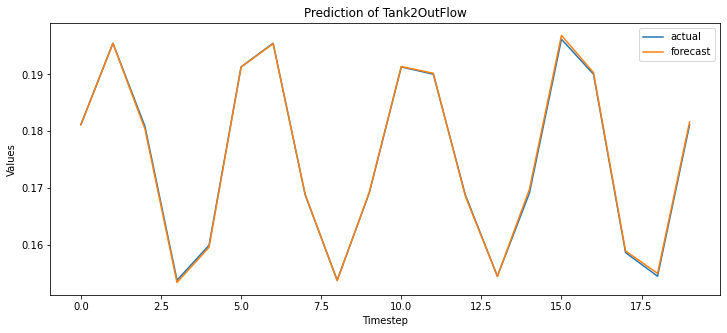

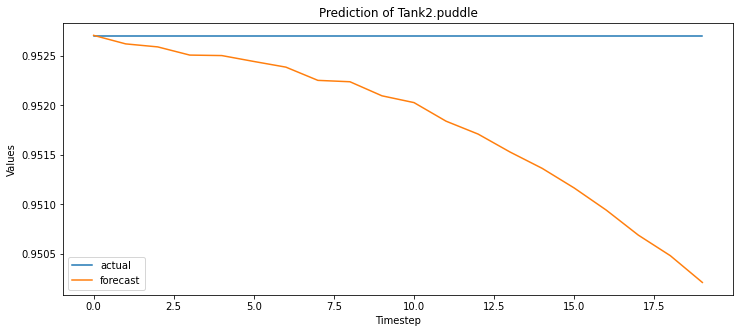

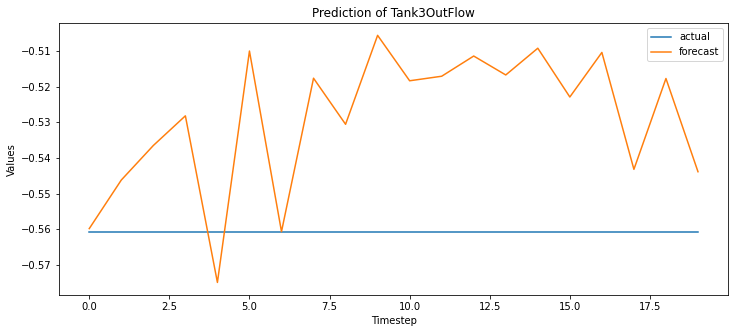

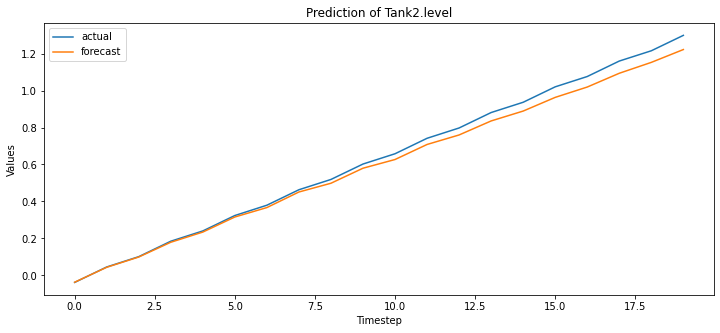

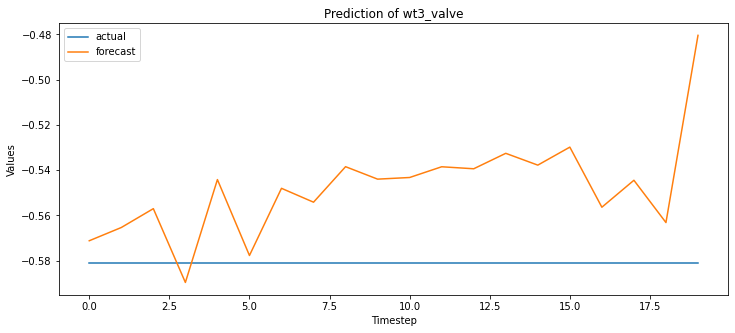

In [68]:
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return

# plot_multiple_series(df_forecast, test.iloc[:20,:], attr)
plot_multiple_series(test.iloc[:20,:], df_forecast, attr)

In [69]:
len(df_forecast)

20

### Plot the results

In [70]:
len(train.iloc[-30:,:])

30

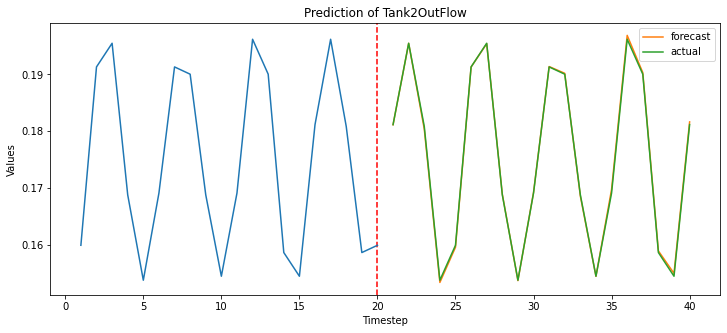

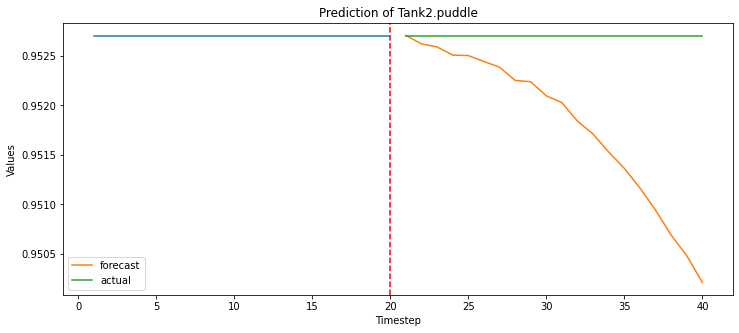

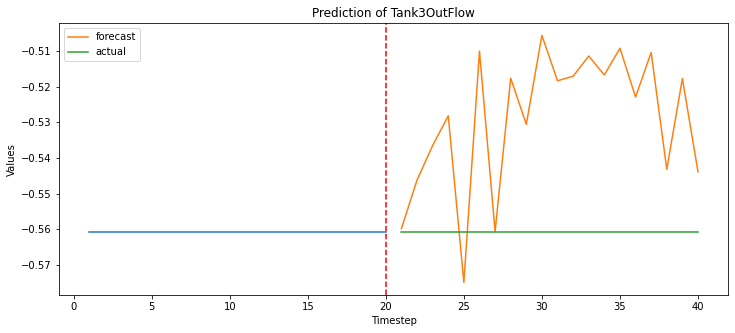

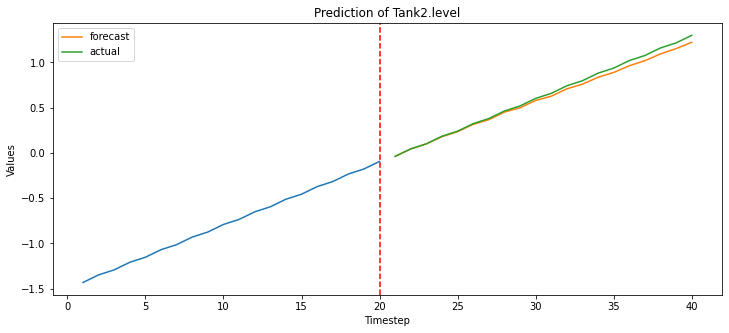

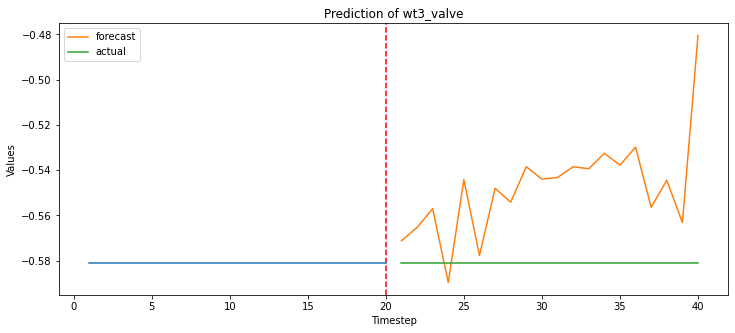

In [71]:
attr = list(pd.read_csv('waterTank_Golden_reduced.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

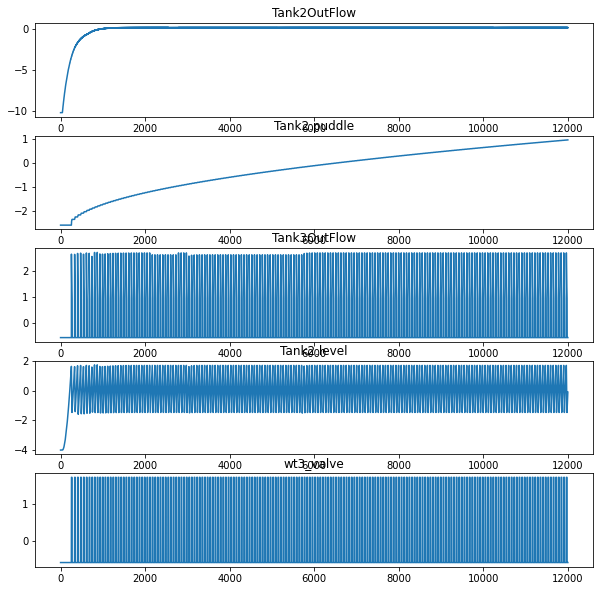

In [72]:
results.plot();

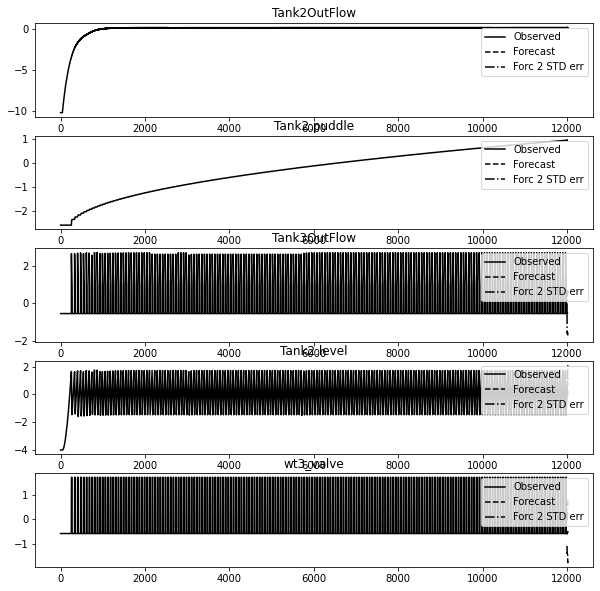

In [73]:
results.plot_forecast(20);

In [74]:
len(df_forecast)

20

### Model Evaluation (Quantitative)

In [75]:
# ### RUBBISH
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# RMSE = []
# for feat in attr:
#     RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

# print(RMSE)

In [76]:
# attr = [Tank2OutFlow', 'Tank2.puddle', 'Tank3OutFlow', 'Tank2.level', 'wt3_valve']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.00032853054616936576, 0.0011599851169652616, 0.03706637204905772, 0.03869166791404186, 0.03979340378574964]


In [77]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)

RMSEme = []
for feat in attr:
    RMSEme.append(root_mse(pred[feat], actual_test[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSEme)

[0.00032853054616936576, 0.0011599851169652616, 0.03706637204905772, 0.03869166791404186, 0.03979340378574964]


### Save the model

In [78]:
# # Serialize andsave the model
# import pickle
# import statsmodels.api as sm
# with open('var_golden_model.pkl', 'wb') as f:
#     pickle.dump(results.params, f)
# print("Model saved!")

with open('var_golden_model_reduced.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")


Model saved!


In [79]:
print("Pause execution")
print(error)

Pause execution


NameError: name 'error' is not defined

### Define the faulty data
##### We need to define a different normalisation function that will use the previous values of means and stds.

In [ ]:
# # Retrieve the saved and stored means and stds
# %store -r stored_norm_var
# old_means = stored_norm_var[0]
# old_stds = stored_norm_var[1]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



In [ ]:
# old_means, old_stds

In [ ]:
import pandas as pd
var_df = pd.read_csv("norm_var.csv", index_col=0)
var_df

In [ ]:
old_means, old_stds = var_df["0"], var_df["1"]

In [ ]:
# faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_df = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)
faulty_df.index.freq = 'MS'
num_obs = 3000

# normalised_data, means, stds = normalise_timeseries(faulty_data)
normalised_data = normalise_series(faulty_df, old_means, old_stds)
faulty_data = normalised_data

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

In [ ]:
faulty_data

### Load the model and reconstruct VAR

In [ ]:
with open('var_golden_model.pkl', 'rb') as f:
    params = pickle.load(f)
    
golden_model = sm.tsa.VAR(train)
golden_model.params = params
golden_model_fit = golden_model.fit(min_aic_index)
# golden_model_fit = golden_model.fit()
golden_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = golden_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
test_faulty

In [ ]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
# fault_forecast = pd.DataFrame(forecast, columns=attr)
# input_length = 20
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index_f = pd.Index(list(range(lag_order)))
#     actual_f = train_faulty.iloc[-lag_order:,:]
    
#     index_f = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual_f = actual_f.set_index(actual_index_f)
#     pred_f = fault_forecast.set_index(index_f)
#     actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual_f.iloc[:,i])
#     plt.plot(pred_f.iloc[:,i], label="forecast")
#     plt.plot(actual_test_f.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()


attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast, columns=attr)
input_length = 20
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(1,input_length+1)))
    actual_f = train_faulty.iloc[-input_length:,:]
    
    index_f = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:input_length,:].set_index(index_f)
    # draw a vertical line at x=20
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(pred_f[feat], actual_test_f[feat]))

print(RMSEf)



Evaluation of the model's performance can be done using the following:
- Accuracy
- Precision
- Recall
- F1 score

In [ ]:
print("I want to stop the execution of the notebook here")
print(error)

### Increasing the duration of faults

In [ ]:
df_test_extend = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_test_extend.index.freq = 'MS'
faulty_data_extend = normalise_timeseries(df_test_extend)

# faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# normalised_data_extend, means, stds = normalise_timeseries(faulty_data_extend)
# faulty_data_extend = normalised_data_extend
faulty_data_extend = df_test_extend

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = golden_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast_extend, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Fault Detection

In [ ]:
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# ndf = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
ndf = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0)
ndf.plot(figsize=(16,6))

In [ ]:
# # Train best multivariate model
# var = VAR(fault_forecast)
# var_result = var.fit(min_aic_index)

# var_result.aic

In [ ]:
# Compute Train T2 metric (Hotelling's T-squared)
residuals_mean = results.resid.values.mean(axis=0)
residuals_std = results.resid.values.std(axis=0)

residuals = (results.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))
T.shape

In [ ]:
# Compute UCL - Upper Control Limit

m = results.nobs
p = results.resid.shape[-1]
alpha = 0.01

# UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL = stats.f.ppf(alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL

In [ ]:
# Set the UCL
UCL = 500

In [ ]:
# Plot Train T2 metric

plt.figure(figsize=(16,6))
# plt.plot(train.index[min_aic_index:], T)
plt.plot(train.index[min_aic_index:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [3]:
print("Print(True)")

Print(True)
